DEEP LEARNING

LAB-8

PRANSHU PARATE

202211063

APPAREL DATASET

Use Apparel images dataset and train multiple output CNN model to classify each dress image's category and color

In [ ]:
#importing packages
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import re
import requests
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import re
import requests

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer

from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, BatchNormalization, Dropout 
from keras.layers import Flatten, Lambda, Input, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1, l2

%config InlineBackend.figure_format = 'svg'


In [ ]:
#mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Input shape for CNN and to resize images
input_shape = (110, 110, 3)

In [ ]:
X = [] # Lists for images data
Y_cat = [] # List to store category of image (dress, shirt etc)
Y_col = [] # List to store color of apparel

# Path to dataset
dataset = '/content/drive/MyDrive/apparel_data/apparel_data'

# Loop through all categories in dataset
for folder in os.listdir(dataset):
    
    # Path to images in certain category
    folder_path = os.path.join(dataset, folder)
    
    # Loop through all images in category
    for i in os.listdir(folder_path):
        
        # Path to certain image (Example: ../input/apparel-images-dataset/blue_dress/11d5fd4203b08f26dac2e7fa2294c6f01babee15.jpg)
        path_to_image = os.path.join(folder_path, i)
        
        # Reading and resizing image to 96x96 pixels size
        image = cv.imread(path_to_image)
        image = cv.resize(image, (input_shape[1], input_shape[0]))
        
        # using regex to extract labels from path_to_image
        labels = re.findall(r'\w+\_\w+', path_to_image) # Gives us ['blue_dress']
        labels = labels[0].split('_') # Gives us ['blue', 'dress']
        
        # Adding data and labels to lists
        X.append(image)
        Y_cat.append(labels[1])
        Y_col.append(labels[0])

In [ ]:
# Convert X to numpy array
X = np.array(X) / 255.0

# Binarizing labels
lb_cat = LabelBinarizer()
Y_cat = lb_cat.fit_transform(Y_cat)

lb_col = LabelBinarizer()
Y_col = lb_col.fit_transform(Y_col)

In [ ]:
# Labels
print('Category classes:')
[print(i) for i in zip(lb_cat.classes_, np.unique(np.argmax(Y_cat, axis = 1)))]

print('\nColor classes:')
[print(i) for i in zip(lb_col.classes_, np.unique(np.argmax(Y_col, axis = 1)))]

Category classes:
('data', 0)

Color classes:
('apparel', 0)


[None]

In [ ]:
# test_x, cat_y_test, col_y_test - for final validation
x, test_x, cat_y, cat_y_test, col_y, col_y_test = train_test_split(X, Y_cat, Y_col, test_size = 0.1, shuffle = True, random_state = 1)

# Train and validation data
train_x, val_x, cat_y_train, cat_y_val, col_y_train, col_y_val = train_test_split(x, cat_y, col_y, test_size = 0.2)

In [ ]:
#model creation and training
inputs = Input(shape = input_shape)

# Category branch
cat = Lambda(lambda z: tf.image.rgb_to_grayscale(z))(inputs)

cat = Conv2D(32, 5, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = Conv2D(32, 5, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = MaxPooling2D()(cat)
cat = Dropout(0.25)(cat)

cat = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = MaxPooling2D()(cat)
cat = Dropout(0.25)(cat)

cat = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = MaxPooling2D()(cat)
cat = Dropout(0.25)(cat)

cat = Flatten()(cat)
cat = Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(cat)
cat = BatchNormalization()(cat)
cat = Dropout(0.5)(cat)
cat = Dense(lb_cat.classes_.shape[0], activation = 'softmax', name = 'cat')(cat)


In [ ]:
#Color branch
col = Conv2D(16, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(inputs)
col = BatchNormalization(axis = -1)(col)
col = MaxPooling2D(3)(col)
col = Dropout(0.25)(col)

col = Conv2D(32, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(col)
col = BatchNormalization(axis = -1)(col)
col = MaxPooling2D()(col)
col = Dropout(0.25)(col)

col = Conv2D(32, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(col)
col = BatchNormalization(axis = -1)(col)
col = MaxPooling2D()(col)
col = Dropout(0.25)(col)

col = Flatten()(col)
col = Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(col)
col = BatchNormalization()(col)
col = Dropout(0.5)(col)
col = Dense(lb_col.classes_.shape[0], activation = 'softmax', name = 'col')(col)


In [ ]:
model = Model(inputs = inputs, outputs = [cat, col])
losses = {'cat': 'categorical_crossentropy',
         'col': 'categorical_crossentropy'}
loss_weights = {'cat': 1.0, 'col': 1.0}

checkpoint = ModelCheckpoint('../working/best_model.hdf5', save_best_only = True, verbose = 1, monitor = 'val_loss')



In [ ]:
#compilation of  model
model.compile(optimizer = 'adam', loss = losses, 
              loss_weights = loss_weights, metrics = ['accuracy'])


In [ ]:
#fitting of model
history = model.fit(train_x, {'cat': cat_y_train, 'col': col_y_train},
         validation_data = (val_x, {'cat': cat_y_val, 'col': col_y_val}),
         batch_size = 128, epochs = 10, callbacks = [checkpoint])

Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 0.0000e+00 - cat_loss: 0.0000e+00 - col_loss: 0.0000e+00 - cat_accuracy: 0.0000e+00 - col_accuracy: 0.0000e+00
Epoch 1: val_loss did not improve from 0.00000
34/34 [==============================] - 11s 308ms/step - loss: 0.0000e+00 - cat_loss: 0.0000e+00 - col_loss: 0.0000e+00 - cat_accuracy: 0.0000e+00 - col_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_cat_loss: 0.0000e+00 - val_col_loss: 0.0000e+00 - val_cat_accuracy: 0.0000e+00 - val_col_accuracy: 0.0000e+00
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.0000e+00 - cat_loss: 0.0000e+00 - col_loss: 0.0000e+00 - cat_accuracy: 0.0000e+00 - col_accuracy: 0.0000e+00
Epoch 2: val_loss did not improve from 0.00000
34/34 [==============================] - 10s 300ms/step - loss: 0.0000e+00 - cat_loss: 0.0000e+00 - col_loss: 0.0000e+00 - cat_accuracy: 0.0000e+00 - col_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_cat_loss: 0.0000e+00 - val_col

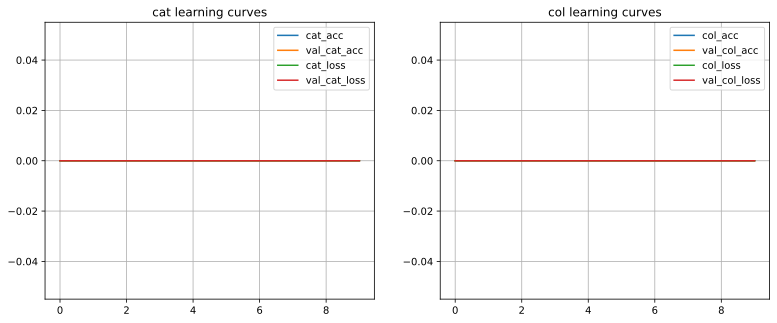

In [ ]:
# Plot learning curves
H = history.history
fig = plt.figure(figsize = (13, 5))

for i, c in enumerate(('cat', 'col')):
    plt.subplot(1, 2, i+1) # change '12' to '1, 2'
    plt.plot(H[f'{c}_accuracy'], label = f'{c}_acc')
    plt.plot(H[f'val_{c}_accuracy'], label = f'val_{c}_acc')
    plt.plot(H[f'{c}_loss'], label = f'{c}_loss')
    plt.plot(H[f'val_{c}_loss'], label = f'val_{c}_loss')
    plt.title(f'{c} learning curves')
    plt.legend()
    plt.grid()


In [ ]:
# Load best weights
model.load_weights('../working/best_model.hdf5')

# Predicting test images
cat_preds, col_preds = model.predict(test_x)
cat_preds = np.argmax(cat_preds, axis = 1)
col_preds = np.argmax(col_preds, axis = 1)

# Creating confusion matrices
cat_confusion = confusion_matrix(np.argmax(cat_y_test, axis = 1), cat_preds)
col_confusion = confusion_matrix(np.argmax(col_y_test, axis = 1), col_preds)

19/19 [==============================] - 0s 15ms/step


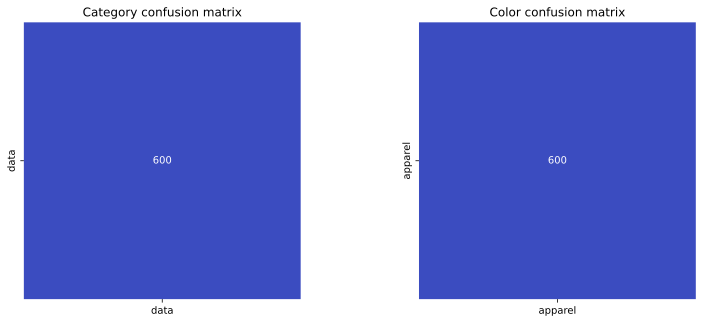

In [ ]:
# Plotting confusion matrices
fig = plt.figure(figsize = (13, 5))

# Category confusion matrix plot
plt.subplot(121)
cat_l = list(lb_cat.classes_)
sns.heatmap(cat_confusion, square = True, annot = True, fmt = 'd', cbar = False, 
            xticklabels = cat_l, yticklabels = cat_l, cmap = 'coolwarm').set_title('Category confusion matrix')

# Color confusion matrix plot
plt.subplot(122)
col_l = list(lb_col.classes_)
sns.heatmap(col_confusion, square = True, annot = True, fmt = 'd', cbar = False, 
            xticklabels = col_l, yticklabels = col_l, cmap = 'coolwarm').set_title('Color confusion matrix')

plt.show()